In [1]:
#!/usr/bin/env python
# encoding: utf-8

In [2]:
import csv
import pandas as pd 
import numpy as np 
from collections import defaultdict
import re
import sys
from sklearn.model_selection import train_test_split
import datetime
import matplotlib.pyplot as plt
import time
import numpy as np
from pprint import pprint
import random
from sklearn.metrics import f1_score
import spacy  # For preprocessing
import nltk
import string
from nltk.corpus import stopwords
import preprocessor as p  #pip install tweet-preprocessor
import logging  # Setting up the loggings to monitor gensim
from nltk.stem import WordNetLemmatizer
from string import punctuation as punc

import gensim
import gensim.corpora as corpora
#from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import gensim.models as gsm
from gensim.test.utils import datapath

import regex
import emoji
# Internal dependencies
import word_emoji2vec as we2v
#from word_emoji2vec import Word_Emoji2Vec

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
import torchvision.transforms as transforms
from torch.autograd import Variable

nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed #python -m spacy download en

torch.manual_seed(1)

In [3]:
########## load embeddings #######
loc_emb = torch.load('data/locationEmbeddings.pt') 
des_emb = torch.load('data/descriptionEmbeddings.pt') 
twt_emb = torch.load('data/tweetsEmbeddings.pt') 

#load network embedding
net_emb = gsm.KeyedVectors.load_word2vec_format('data/userNetworkEmd.emd')

In [4]:
#user = net_emb ['000mrs000']
#print(user)
print(type(net_emb))

<class 'gensim.models.keyedvectors.Word2VecKeyedVectors'>


In [5]:
#Load 1300 user location, description, yoga tweets, utype, umotivation
df = pd.read_csv("data/yoga_user_name_loc_des_mergetweets_yoga_1300_lb.csv") 
#print (df) #[1308 rows x 7 columns] name, location, description, text, utype, umotivation

In [6]:
##### load train users and split into train and validation #######
with open("data/train.txt", "r") as f:
    data = f.read().split('\n')
random.seed(1)
random.shuffle(data)

train_data = data[:830] #80% train  
#print(train_data, len(train_data)) #830
valid_data = data[830:] #20% validation
#print(valid_data)


In [7]:
########## Create BiLSTMAttention Model for Description
class BiLSTMDesAtt(nn.Module):
    def __init__(self):
        super(BiLSTMDesAtt, self).__init__() 
        self.lstm = nn.LSTM(300, 150//2 , num_layers=1, bidirectional=True ) #BiLSTM with attention 
        #self.lstm = nn.LSTM(300, 150 , num_layers=1, bidirectional=False) #LSTM with attention
        self.fc2 = nn.Linear(150, 50)
        self.hidden = self.init_hidden() # <- change here 
        self.attn_fc = torch.nn.Linear(300, 1) #attention layer
    
    def init_hidden(self):
        #(2*self.num_layers, batch_size, self.hidden_dim // 2)
        return (torch.zeros(2 * 1, 1, 150//2), torch.zeros(2 * 1, 1, 150//2)) # <- change here: first dim of hidden needs to be doubled
        #return (torch.zeros(1 * 1, 1, 150), torch.zeros(1 * 1, 1, 150))#LSTM with attention
    def attention(self, rnn_out, state):
        #print("rnn_out", rnn_out.size()) #torch.Size([13, 1, 150])
        #rnn_out = rnn_out.squeeze(0).unsqueeze(1) 
        #rnn_out = rnn_out.permute(2,0,1) 
        rnn_out = rnn_out.permute(1,0,2) 
        #print("permute rnn_out", rnn_out.size()) #torch.Size([150, 13, 1])
        #print("state", state.size()) #torch.Size([2, 1, 75])
        merged_state = torch.cat([s for s in state],1)
        #print("merged_state", merged_state.size()) #torch.Size([1, 150])
        #print("merged_state2 :", merged_state.squeeze(0).size()) #torch.Size([150])
        #print("merged_state2 :", merged_state.squeeze(0).unsqueeze(1).size()) #torch.Size([150, 1])
        #print("merged_state2 :", merged_state.squeeze(0).unsqueeze(1).unsqueeze(2).size()) # torch.Size([150, 1, 1])
        #merged_state = merged_state.squeeze(0).unsqueeze(2)
        merged_state = merged_state.squeeze(0).unsqueeze(1).unsqueeze(2)
        #print("merged_state2 :", merged_state.size()) #torch.Size([150, 1, 1])
        merged_state = merged_state.permute(1,0,2)
        # (batch, seq_len, cell_size) * (batch, cell_size, 1) = (batch, seq_len, 1)
        weights = torch.bmm(rnn_out, merged_state)
        #print("weights", weights.size()) #torch.Size([150, 13, 1])
        #weights = torch.nn.functional.softmax(weights.squeeze(2)).unsqueeze(2)
        weights = F.log_softmax(weights.squeeze(2),dim = 1).unsqueeze(2)
         #F.log_softmax(x, dim = 1)
        #print("weights2 :", weights.size()) #torch.Size([150, 13, 1])
        # (batch, cell_size, seq_len) * (batch, seq_len, 1) = (batch, cell_size, 1)
        return torch.bmm(torch.transpose(rnn_out, 1, 2), weights).squeeze(2)
    # end method attention

    def forward(self, X):
        #print(X.size()) # torch.Size([13, 300])
        #print('resize', x.view(len(x),1,-1), x.view(len(x),1,-1).size()) #torch.Size([13, 1, 300])
        lstm_out, hidden = self.lstm(X.view(len(X),1, -1))
        #print('lstm_out', lstm_out, lstm_out.size()) # torch.Size([13, 1, 150])
        #print('hidden[0] = h_n', hidden[0], hidden[0].size()) # torch.Size([2, 1, 75])
        #print('hidden[1] = c_n', hidden[1], hidden[1].size()) # torch.Size([2, 1, 75])
        h_n, c_n = hidden
        #print('h_n', h_n, h_n.size()) # torch.Size([2, 1, 75])
        #print('c_n', c_n, hidden[1].size()) # torch.Size([2, 1, 75])
        attn_out = self.attention(lstm_out, h_n)
        #print("attn_out", attn_out.size()) #torch.Size([150, 1])
        #logits = self.fc2(attn_out)
        #logits = self.fc2(attn_out.permute(1,0))
        #print("logits", logits, logits.size())
        #return logits 
        return attn_out
    


In [8]:
########## Create BiLSTMAttention Model for Description
class BiLSTMTwtAtt(nn.Module):
    def __init__(self):
        super(BiLSTMTwtAtt, self).__init__() 
        self.lstm = nn.LSTM(300, 150//2 , num_layers=1, bidirectional=True ) #BiLSTM with attention 
        #self.lstm = nn.LSTM(300, 150 , num_layers=1, bidirectional=False) #LSTM with attention
        self.fc2 = nn.Linear(150, 50)
        self.hidden = self.init_hidden() # <- change here 
        self.attn_fc = torch.nn.Linear(300, 1) #attention layer
    
    def init_hidden(self):
        #(2*self.num_layers, batch_size, self.hidden_dim // 2)
        return (torch.zeros(2 * 1, 1, 150//2), torch.zeros(2 * 1, 1, 150//2)) # <- change here: first dim of hidden needs to be doubled
        #return (torch.zeros(1 * 1, 1, 150), torch.zeros(1 * 1, 1, 150))#LSTM with attention
    def attention(self, rnn_out, state):
        #print("rnn_out", rnn_out.size()) #torch.Size([13, 1, 150])
        #rnn_out = rnn_out.squeeze(0).unsqueeze(1) 
        #rnn_out = rnn_out.permute(2,0,1) 
        rnn_out = rnn_out.permute(1,0,2) 
        #print("permute rnn_out", rnn_out.size()) #torch.Size([150, 13, 1])
        #print("state", state.size()) #torch.Size([2, 1, 75])
        merged_state = torch.cat([s for s in state],1)
        #print("merged_state", merged_state.size()) #torch.Size([1, 150])
        #print("merged_state2 :", merged_state.squeeze(0).size()) #torch.Size([150])
        #print("merged_state2 :", merged_state.squeeze(0).unsqueeze(1).size()) #torch.Size([150, 1])
        #print("merged_state2 :", merged_state.squeeze(0).unsqueeze(1).unsqueeze(2).size()) # torch.Size([150, 1, 1])
        #merged_state = merged_state.squeeze(0).unsqueeze(2)
        merged_state = merged_state.squeeze(0).unsqueeze(1).unsqueeze(2)
        #print("merged_state2 :", merged_state.size()) #torch.Size([150, 1, 1])
        merged_state = merged_state.permute(1,0,2)
        # (batch, seq_len, cell_size) * (batch, cell_size, 1) = (batch, seq_len, 1)
        weights = torch.bmm(rnn_out, merged_state)
        #print("weights", weights.size()) #torch.Size([150, 13, 1])
        #weights = torch.nn.functional.softmax(weights.squeeze(2)).unsqueeze(2)
        weights = F.log_softmax(weights.squeeze(2),dim = 1).unsqueeze(2)
         #F.log_softmax(x, dim = 1)
        #print("weights2 :", weights.size()) #torch.Size([150, 13, 1])
        # (batch, cell_size, seq_len) * (batch, seq_len, 1) = (batch, cell_size, 1)
        return torch.bmm(torch.transpose(rnn_out, 1, 2), weights).squeeze(2)
    # end method attention

    def forward(self, X):
        #print(X.size()) # torch.Size([13, 300])
        #print('resize', x.view(len(x),1,-1), x.view(len(x),1,-1).size()) #torch.Size([13, 1, 300])
        lstm_out, hidden = self.lstm(X.view(len(X),1, -1))
        #print('lstm_out', lstm_out, lstm_out.size()) # torch.Size([13, 1, 150])
        #print('hidden[0] = h_n', hidden[0], hidden[0].size()) # torch.Size([2, 1, 75])
        #print('hidden[1] = c_n', hidden[1], hidden[1].size()) # torch.Size([2, 1, 75])
        h_n, c_n = hidden
        #print('h_n', h_n, h_n.size()) # torch.Size([2, 1, 75])
        #print('c_n', c_n, hidden[1].size()) # torch.Size([2, 1, 75])
        attn_out = self.attention(lstm_out, h_n)
        #print("attn_out", attn_out.size()) #torch.Size([150, 1])
        #logits = self.fc2(attn_out)
        #logits = self.fc2(attn_out.permute(1,0))
        #print("logits", logits, logits.size())
        #return logits 
        return attn_out
    


In [9]:
########## Create LSTM Model for Location #############
class LSTMLoc(nn.Module):
    def __init__(self):
        super(LSTMLoc, self).__init__()
        self.lstm = nn.LSTM(300, 150, num_layers=1)
        self.fc2 = nn.Linear(150, 50) 
        self.hidden = self.init_hidden() # <- change here 

    def init_hidden(self):
        #(2*self.num_layers, batch_size, self.hidden_dim // 2)# <- change here: first dim of hidden needs to be doubled
        return (torch.zeros(1, 1, 150), torch.zeros(1, 1, 150)) 
    def forward(self, x):
        #x=embeds.permute(1,0,2)
        #print('resize', x.view(len(x),1,-1), x.view(len(x),1,-1).size()) #torch.Size([13, 1, 300])
        #lstm_out, self.hidden = self.lstm(x.view(len(x),1, -1), self.hidden)
        lstm_out, _ = self.lstm(x.view(len(x),1, -1))
        #lstm_out, _ = self.lstm(x.view(len(x),1,-1)) 
        #print('lstm_out', lstm_out, lstm_out.size()) # torch.Size([13, 1, 150])
        #print('self.hidden[0]', self.hidden[0], self.hidden[0].size()) # torch.Size([1, 1, 150])
        #print("lstm_out[-1]", lstm_out[-1], lstm_out[-1].size())  # torch.Size([1, 150])
        #x = self.fc2(lstm_out[-1])  
        #out = F.log_softmax(x, dim = 1)
        #return out
        #return x
        return lstm_out[-1]
    

In [10]:
########## Create Model 
class NetworkMLP(nn.Module):
    def __init__(self):
        super(NetworkMLP, self).__init__() 
        self.fc1 = nn.Linear(300, 150)
        self.fc2 = nn.Linear(150, 50)
        
    def forward(self, X):
        #print(X.size()) # torch.Size([300])
        #print('resize', X.view(1,len(X)).size()) #resize torch.Size([1, 300])
        z1 = self.fc1(X.view(1,len(X)))
        #print('z1', z1, z1.size()) # torch.Size([1, 150])
        h1 = F.relu(z1)
        return h1
        #logits = self.fc2(h1) #without attention
        #print("logits", logits, logits.size()) #torch.Size([1, 3])
        #return logits 
    


In [11]:
class JointDLTN(nn.Module):
    def __init__(self):
        super(JointDLTN, self).__init__()
        self.model_des = BiLSTMDesAtt()
        self.model_loc = LSTMLoc()
        #self.model_twt = BiLSTMDesAtt()
        self.model_twt = BiLSTMTwtAtt()
        self.model_net = NetworkMLP()
        #self.fc = nn.Linear(200, 3) #4*50 = 150
        self.fc1 = nn.Linear(600, 200) #4*150 = 600
        self.fc2 = nn.Linear(200, 3)
#        self.fc1 = nn.Linear(600, 3)
    def forward(self, x_d, x_l, x_t, x_n): 
        prediction_des = self.model_des(x_d)
        #print(prediction_des, prediction_des.size())
        prediction_loc = self.model_loc(x_l)
        #print(prediction_loc, prediction_loc.size())
        prediction_twt = self.model_twt(x_t)
        prediction_net = self.model_net(x_n)
        concat_pred = torch.cat((prediction_des, prediction_loc, prediction_twt, prediction_net), 1) #concat with dim= 1
        #print(concat_pred, concat_pred.size()) 
#         out = F.log_softmax(self.fc(concat_pred), dim = 1)
#         return out
        out = self.fc1(concat_pred)
        out = self.fc2(F.relu(out))
        out = F.log_softmax(out, dim = 1)
        return out



In [12]:
#####prepare data for neural net input #########
def nn_input(train_data,df):
    #ground_truths = []
    training_data_des =[]
    training_data_loc=[]
    training_data_twt =[]
    for i in range (0, len(train_data)):
    #for i in range (0, 10):
        for j in range (0,df.shape[0]):
            if (train_data[i] == df.name[j]):
                if (not des_emb[train_data[i]]) and (not loc_emb[train_data[i]]) and (twt_emb[train_data[i]]):
                    print ('no description and location for user: ', train_data[i])
                    training_data_des.append(torch.zeros(1, 300))
                    training_data_loc.append(torch.zeros(1, 300))
                    sent_tensor_twt = torch.stack(twt_emb[train_data[i]],dim = 1)
                    training_data_twt.append(sent_tensor_twt[-1])
                    break
                
                elif (des_emb[train_data[i]]) and (not loc_emb[train_data[i]]) and (twt_emb[train_data[i]]): 
                    print ('no location for user: ', train_data[i])
                    sent_tensor_des = torch.stack(des_emb[train_data[i]],dim = 1)
                    training_data_des.append(sent_tensor_des[-1])
                    training_data_loc.append(torch.zeros(1, 300))
                    sent_tensor_twt = torch.stack(twt_emb[train_data[i]],dim = 1)
                    training_data_twt.append(sent_tensor_twt[-1])
                    break
                    
                elif (not des_emb[train_data[i]]) and (loc_emb[train_data[i]]) and (twt_emb[train_data[i]]): 
                    print ('no description for user: ', train_data[i])
                    training_data_des.append(torch.zeros(1, 300))
                    sent_tensor_loc = torch.stack(loc_emb[train_data[i]],dim = 1)
                    training_data_loc.append(sent_tensor_loc[-1])
                    sent_tensor_twt = torch.stack(twt_emb[train_data[i]],dim = 1)
                    training_data_twt.append(sent_tensor_twt[-1])
                    break    
               
                elif (des_emb[train_data[i]]) and (loc_emb[train_data[i]]) and (twt_emb[train_data[i]]): 
                    sent_tensor_des = torch.stack(des_emb[train_data[i]],dim = 1)
                    training_data_des.append(sent_tensor_des[-1])
                    sent_tensor_loc = torch.stack(loc_emb[train_data[i]],dim = 1)
                    training_data_loc.append(sent_tensor_loc[-1])
                    sent_tensor_twt = torch.stack(twt_emb[train_data[i]],dim = 1)
                    training_data_twt.append(sent_tensor_twt[-1])
                    break
    return training_data_des, training_data_loc, training_data_twt


In [13]:
#####prepare data for neural net #########
def nn_input_network(train_data,df):
    training_data =[]
    for i in range (0, len(train_data)):
    #for i in range (0, 10):
        for j in range (0,df.shape[0]):
            if (train_data[i] == df.name[j]):
                #print(train_data[i]) #print username
                utype =  [int(df.utype[j])]
                umotivation = [int(float(df.umotivation[j]))]
                #print ("net_emb[train_data[i]] : ", net_emb[train_data[i]], type(net_emb[train_data[i]]), torch.Tensor(net_emb[train_data[i]]), type(torch.Tensor(net_emb[train_data[i]])))
                #count = 0
                if(train_data[i] not in net_emb ):
                    net_emb[train_data[i]] = np.zeros(300) #For users not appearing in the mention network, we set their network embedding vectors as 0.
                    #count = count + 1
                #print(count)
                #print(net_emb[train_data[i]]) #ok
                ####.....convert ndarray to torch.tensor........
                net_emb_tensor = torch.Tensor(net_emb[train_data[i]])
                #print(net_emb_tensor) #ok
                training_data.append(net_emb_tensor)
                break
    return training_data


In [14]:
#####Ground Truth #########
def find_groundtruth(data, df):
    ground_truths = []
    for i in range (0, len(data)):
    #for i in range (0, 10):
        for j in range (0,df.shape[0]):
            if (data[i] == df.name[j]):
                #print(data[i]) #print username
                utype =  [int(df.utype[j])]
                umotivation = [int(float(df.umotivation[j]))]
                target_type = torch.tensor(utype, dtype=torch.long) #for user type
                #target_type = torch.tensor(umotivation, dtype=torch.long) #for user motivation
                ground_truths.append(target_type)
    return ground_truths

In [15]:
###########........Load the trained model and make prediction and calculate accuracy.....
def make_prediction_tr(model, training_data_des, training_data_loc, training_data_twt, training_data_net, ground_truths):
    predictions =[]
    for i in range (0,len(training_data_des)):
        prediction_joint = model(training_data_des[i], training_data_loc[i], training_data_twt[i], training_data_net[i])
        
        #prediction = model(data[i])
        pred = torch.argmax(prediction_joint, dim=1)
        #print("pred :", pred) #ok
        #print("ground_truths :", ground_truths[i]) #ok
        predictions.append(pred.item())
    #accuracy = np.sum(np.array(predictions) == np.array(ground_truths)) /10
    accuracy = np.sum(np.array(predictions) == np.array(ground_truths)) /len(training_data_des)
    macro_f1 = f1_score(ground_truths, predictions, average='macro')
    
    return accuracy, macro_f1
  

In [16]:
###########........Load the trained model and make prediction and calculate accuracy.....
def make_prediction_val(model, training_data_des, training_data_loc, training_data_twt, training_data_net, ground_truths):
    predictions =[]
    val_losses = []
    loss_function = nn.NLLLoss()
    for i in range (0,len(training_data_des)):
        prediction_joint = model(training_data_des[i], training_data_loc[i], training_data_twt[i], training_data_net[i])
        val_loss = loss_function(prediction_joint, ground_truths[i])
        val_losses.append(val_loss.item())
        #prediction = model(data[i])
        pred = torch.argmax(prediction_joint, dim=1)
        #print("pred :", pred) #ok
        #print("ground_truths :", ground_truths[i]) #ok
        predictions.append(pred.item())
    #accuracy = np.sum(np.array(predictions) == np.array(ground_truths)) /10
    accuracy = np.sum(np.array(predictions) == np.array(ground_truths)) /len(training_data_des)
    macro_f1 = f1_score(ground_truths, predictions, average='macro')
    
    return accuracy, macro_f1, val_losses
  

In [17]:
##########......prepare training and validation data
# ground truth training
train_gt = find_groundtruth(train_data, df)
#####prepare training data for neural net #########
training_data_net =  nn_input_network(train_data,df)
#print(training_data_net, len(training_data_net)) #ok
training_data_des, training_data_loc, training_data_twt =  nn_input(train_data,df)

# ground truth validation
valid_gt = find_groundtruth(valid_data, df)
#####prepare validation data for neural net #########
validation_data_net =  nn_input_network(valid_data,df)
validation_data_des, validation_data_loc, validation_data_twt =  nn_input(valid_data,df)


no description for user:  bchi49
no location for user:  Christoph_Tran
no description for user:  viecestlavie
no description for user:  crystalization_
no location for user:  yogitimesonline
no description for user:  mimmosamami
no description for user:  wenmarbyoga
no location for user:  cipherEquality
no description for user:  YogaLifeLine
no location for user:  thewaywecame


In [18]:
###########.........Start Training...........
model = JointDLTN()
##### Hyperparameter
learning_rate=0.01
epochs = 30
#opt="ADAM"
#opt="SGD" 
opt="ADA"
if(opt=="SGD"):
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
elif(opt=="ADA"):
    optimizer = optim.Adadelta(model.parameters(), lr=learning_rate, eps=1e-06, weight_decay=0.0001)
elif(opt=="ADAM"):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)

    
loss_function = nn.NLLLoss()
#loss_function = nn.CrossEntropyLoss()

check_val_acc = 0
losses = []
per_epoch_train_loss =[]
per_epoch_val_loss =[]
per_epoch_train_f1 =[]
per_epoch_val_f1 = []
for epoch in range(epochs): 
    print('*************** Starting with epoch: ', epoch, '***********************')
    for i in range (0,len(train_data)):
        #model_des.zero_grad()
        #model_loc.zero_grad()
        model.zero_grad()
        #####Run forward pass.
      
        prediction_joint = model(training_data_des[i], training_data_loc[i], training_data_twt[i], training_data_net[i])
        
        #print("prediction_joint :", torch.argmax(prediction_joint, dim=1)) #ok
        #print("ground_truths :", ground_truths[i]) #ok
        #Compute the loss, gradients, and update the parameters by
        #calling optimizer.step()
        loss = loss_function(prediction_joint, train_gt[i])
        #if (i%200 == 0):
            #print ("loss per example", loss.item())
        losses.append(loss.item())
        loss.backward(retain_graph=True)  #backpropagation
        optimizer.step()
    accuracy, macro_f1 = make_prediction_tr(model, training_data_des, training_data_loc, training_data_twt, training_data_net, train_gt)
    print('epoch :', epoch, 'Train accuracy and macro_f1:', accuracy, macro_f1)
    per_epoch_train_f1.append(macro_f1)
    val_accuracy, val_macro_f1, val_loss = make_prediction_val(model, validation_data_des, validation_data_loc, validation_data_twt, validation_data_net, valid_gt)
    per_epoch_val_f1.append(val_macro_f1)
    print('epoch :', epoch, 'Validation accuracy, macro_f1:', val_accuracy, val_macro_f1)
    per_epoch_train_loss.append(np.mean(losses))
    print("train loss per epoch", np.mean(losses))
    per_epoch_val_loss.append(np.mean(val_loss))
    print('Validation loss per epoch:', np.mean(val_loss))
    torch.save(model.state_dict(),"data/DLTN_utype_2layer/joint_DLTN_"+str(epoch)+".pt")
#     if (check_val_acc < val_macro_f1): #early stopping
#         check_val_acc = val_macro_f1
#         print ("Model saved at epoch :", epoch)
#         torch.save(model.state_dict(),"data/joint_DLT.pt")
#         best_epoch = epoch
        
#print("Best model found at epoch : ", best_epoch)        
#torch.save(model.state_dict(),"data/joint_DLT.pt")
    

*************** Starting with epoch:  0 ***********************
epoch : 0 Train accuracy and macro_f1: 0.6168674698795181 0.6070941304656783
epoch : 0 Validation accuracy, macro_f1: 0.558252427184466 0.5382135724104044
train loss per epoch 1.0803689160978938
Validation loss per epoch: 1.0206916216507698
*************** Starting with epoch:  1 ***********************
epoch : 1 Train accuracy and macro_f1: 0.6759036144578313 0.6681920510413196
epoch : 1 Validation accuracy, macro_f1: 0.5922330097087378 0.5760117374930703
train loss per epoch 0.9565686763051044
Validation loss per epoch: 0.9245513527138719
*************** Starting with epoch:  2 ***********************
epoch : 2 Train accuracy and macro_f1: 0.7024096385542169 0.6969749495072196
epoch : 2 Validation accuracy, macro_f1: 0.5922330097087378 0.576710285571045
train loss per epoch 0.8853422805487391
Validation loss per epoch: 0.8783109355898737
*************** Starting with epoch:  3 ***********************
epoch : 3 Train accu

epoch : 27 Train accuracy and macro_f1: 0.8506024096385543 0.8481508265217422
epoch : 27 Validation accuracy, macro_f1: 0.6941747572815534 0.6863432025550343
train loss per epoch 0.4926108660224485
Validation loss per epoch: 1.002454172494342
*************** Starting with epoch:  28 ***********************
epoch : 28 Train accuracy and macro_f1: 0.8518072289156626 0.849225649535765
epoch : 28 Validation accuracy, macro_f1: 0.6990291262135923 0.6902899139741244
train loss per epoch 0.4859460501049037
Validation loss per epoch: 1.0188604661272567
*************** Starting with epoch:  29 ***********************
epoch : 29 Train accuracy and macro_f1: 0.8530120481927711 0.8503537204861487
epoch : 29 Validation accuracy, macro_f1: 0.6941747572815534 0.6859428730729205
train loss per epoch 0.47946176159633214
Validation loss per epoch: 1.0409411987633381


<Figure size 432x288 with 0 Axes>

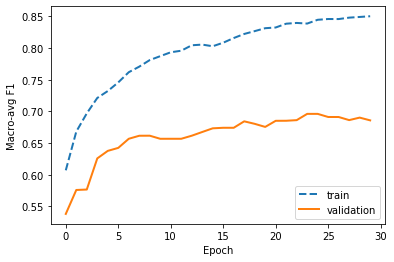

In [19]:
def save_plots(train_losses, val_losses, train_accs, test_accs):
    """Plot

        Plot two figures: loss vs. epoch and accuracy vs. epoch
    """
    n = len(train_losses)
    xs = np.arange(n)

    # plot losses
    fig, ax = plt.subplots()
    ax.plot(xs, train_losses, '--', linewidth=2, label='train loss')
    ax.plot(xs, val_losses, '-', linewidth=2, label='validation loss')
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend(loc='upper right')
    plt.savefig('loss_DLTN_utype_2layer.png')

    # plot train and test accuracies
    plt.clf()
    fig, ax = plt.subplots()
    ax.plot(xs, train_accs, '--', linewidth=2, label='train')
    ax.plot(xs, test_accs, '-', linewidth=2, label='validation')
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Macro-avg F1")
    ax.legend(loc='lower right')
    plt.savefig('accuracy_DLTN_utype_2layer.png')
    
save_plots(per_epoch_train_loss, per_epoch_val_loss, per_epoch_train_f1, per_epoch_val_f1)
# print(per_epoch_train_loss)
# print(per_epoch_val_loss)

In [20]:
# ###########........Load the trained model and make prediction and calculate accuracy.....
# def make_prediction(training_data_des, training_data_loc, training_data_twt, training_data_net, ground_truths):
#     model = JointDLTN()
#     #model.load_state_dict(torch.load("data/YUN_utype/joint_DLTN_14.pt")) #Testing accuracy, macro_f1: 0.7633587786259542 0.6908145811582292
#     #model.load_state_dict(torch.load("data/YUN_utype/joint_DLTN_19.pt")) #Testing accuracy, macro_f1: 0.767175572519084 0.714798206278027
#     #model.load_state_dict(torch.load("data/YUN_utype/joint_DLTN_11.pt")) #best #Testing accuracy, macro_f1: 0.7862595419847328 0.7560951140518181
#     #model.load_state_dict(torch.load("data/YUN_utype_overfit/joint_DLTN_16.pt")) #Testing accuracy, macro_f1: 0.7442748091603053 0.6970324361628709
#     model.load_state_dict(torch.load("data/YUN_utype_overfit/joint_DLTN_23.pt")) #Testing accuracy, macro_f1: 0.7213740458015268 0.6876262717476371
#     predictions =[]
#     for i in range (0,len(training_data_des)):
#         prediction_joint = model(training_data_des[i], training_data_loc[i], training_data_twt[i], training_data_net[i])
#         pred = torch.argmax(prediction_joint, dim=1)
#         predictions.append(pred.item())
#     #accuracy = np.sum(np.array(predictions) == np.array(ground_truths)) /10
#     accuracy = np.sum(np.array(predictions) == np.array(ground_truths)) /len(training_data_des)
#     macro_f1 = f1_score(ground_truths, predictions, average='macro')
    
#     return accuracy, macro_f1

###########........Load the trained model and make prediction and calculate accuracy.....
def make_prediction(training_data_des, training_data_loc, training_data_twt, training_data_net, ground_truths):
    for epoch in range(0,30):
        model = JointDLTN()
        model.load_state_dict(torch.load("data/DLTN_utype_2layer/joint_DLTN_"+str(epoch)+".pt")) #best #Testing accuracy, macro_f1: 0.7862595419847328 0.7560951140518181
        predictions =[]
        for i in range (0,len(training_data_des)):
            prediction_joint = model(training_data_des[i], training_data_loc[i], training_data_twt[i], training_data_net[i])
            pred = torch.argmax(prediction_joint, dim=1)
            predictions.append(pred.item())
        #accuracy = np.sum(np.array(predictions) == np.array(ground_truths)) /10
        accuracy = np.sum(np.array(predictions) == np.array(ground_truths)) /len(training_data_des)
        macro_f1 = f1_score(ground_truths, predictions, average='macro')
        print('epoch :', epoch, 'Testing accuracy, macro_f1:', accuracy, macro_f1)
        #return accuracy, macro_f1
  

In [21]:
########.....Load Test data.......
with open("data/test.txt", "r") as f:
    data = f.read().split('\n')
test_data = data[:] 
#print(test_data, len(test_data)) #262

In [22]:
#####prepare testing data for neural net #########
testing_data_des, testing_data_loc, testing_data_twt =  nn_input(test_data,df)
testing_data_net =  nn_input_network(test_data,df)
test_gt = find_groundtruth(test_data, df)

no location for user:  vaibhavatttc


In [23]:
# ###########........Calculate Validation Accuracy.......
# test_accuracy, test_macro_f1 = make_prediction(testing_data_des, testing_data_loc, testing_data_twt, testing_data_net, test_gt)
# print('Testing accuracy, macro_f1:', test_accuracy, test_macro_f1)



In [24]:
make_prediction(testing_data_des, testing_data_loc, testing_data_twt, testing_data_net, test_gt)


epoch : 0 Testing accuracy, macro_f1: 0.6183206106870229 0.5666650584896916
epoch : 1 Testing accuracy, macro_f1: 0.7022900763358778 0.6625661375661376
epoch : 2 Testing accuracy, macro_f1: 0.7137404580152672 0.6793524255480777
epoch : 3 Testing accuracy, macro_f1: 0.7404580152671756 0.7094385929031599
epoch : 4 Testing accuracy, macro_f1: 0.7557251908396947 0.7284603147031495
epoch : 5 Testing accuracy, macro_f1: 0.7557251908396947 0.7255565610859729
epoch : 6 Testing accuracy, macro_f1: 0.7519083969465649 0.7214422647581721
epoch : 7 Testing accuracy, macro_f1: 0.7480916030534351 0.7178190590694422
epoch : 8 Testing accuracy, macro_f1: 0.7557251908396947 0.7244198747416646
epoch : 9 Testing accuracy, macro_f1: 0.767175572519084 0.7357656721872775
epoch : 10 Testing accuracy, macro_f1: 0.7633587786259542 0.7329534373951776
epoch : 11 Testing accuracy, macro_f1: 0.7633587786259542 0.7322398446101209
epoch : 12 Testing accuracy, macro_f1: 0.7633587786259542 0.7311609155871449
epoch : 13